In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# **DataSet**

In [3]:
# Define paths and constants
data_dir = "/content/drive/MyDrive/Dataset/original_dataset/train"
test_dir = "/content/drive/MyDrive/Dataset/original_dataset/test"
batch_size = 32
target_size = (224, 224)
epochs = 50

In [4]:
# Create an ImageDataGenerator with VGG16 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16-specific preprocessing
  # Fill in missing pixels using the nearest neighbor
    validation_split=0.2
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='validation',          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)

# ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 1191 images belonging to 2 classes.
Found 297 images belonging to 2 classes.
Training samples: 1191
Validation samples: 297
Training batches per epoch: 38
Validation batches per epoch: 10


In [5]:
# Create an ImageDataGenerator for VGG16 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16-specific preprocessing
    validation_split=0.2
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 373 images belonging to 2 classes.
Test samples: 373
Test batches: 12


# **Model Architecture**

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD

def create_model():
   # Load VGG16 model with pretrained weights, excluding the top (fully connected) layers
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Build the model
    model = Sequential()
    for layer in vgg16_base.layers:
       model.add(layer)

# Freeze the layers of VGG16 to retain the pre-trained weights
    for layer in model.layers:
      layer.trainable = False # Not trainable weights

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    # Compile the model with binary crossentropy loss and an SGD optimizer
    model.compile(optimizer = "adam" , loss = "binary_crossentropy", metrics=["accuracy"])


    return model

# Create the model
model = create_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,203,521 (80.89 MB)

 Trainable params: 6,488,833 (24.75 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# **Training**

In [7]:
# Define callbacks
checkpoint_path = "/content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_original_{epoch:02d}-{val_accuracy:0.2f}.keras"
model_dir = "/content/drive/MyDrive/VGG16_Model"
# ModelCheckpoint: Save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(patience = 5)

# Train the model
History = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping_monitor]
)
model.save('/content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_best_model_original.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.7535 - loss: 6.2925
Epoch 1: val_accuracy improved from -inf to 0.45791, saving model to /content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_original_01-0.46.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7560 - loss: 6.2304 - val_accuracy: 0.4579 - val_loss: 24.2457
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9768 - loss: 0.5156
Epoch 2: val_accuracy improved from 0.45791 to 0.55892, saving model to /content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_original_02-0.56.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 987ms/step - accuracy: 0.9768 - loss: 0.5156 - val_accuracy: 0.5589 - val_loss: 46.4329
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9777 - loss: 0.9483
Epoch 3: val_accuracy did not improve from 0.55892
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 949ms/step - accuracy: 0.9778 - loss: 0.9395 - val_accuracy: 0.5118 - val_loss: 33.3852
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━

# **History Plotting**

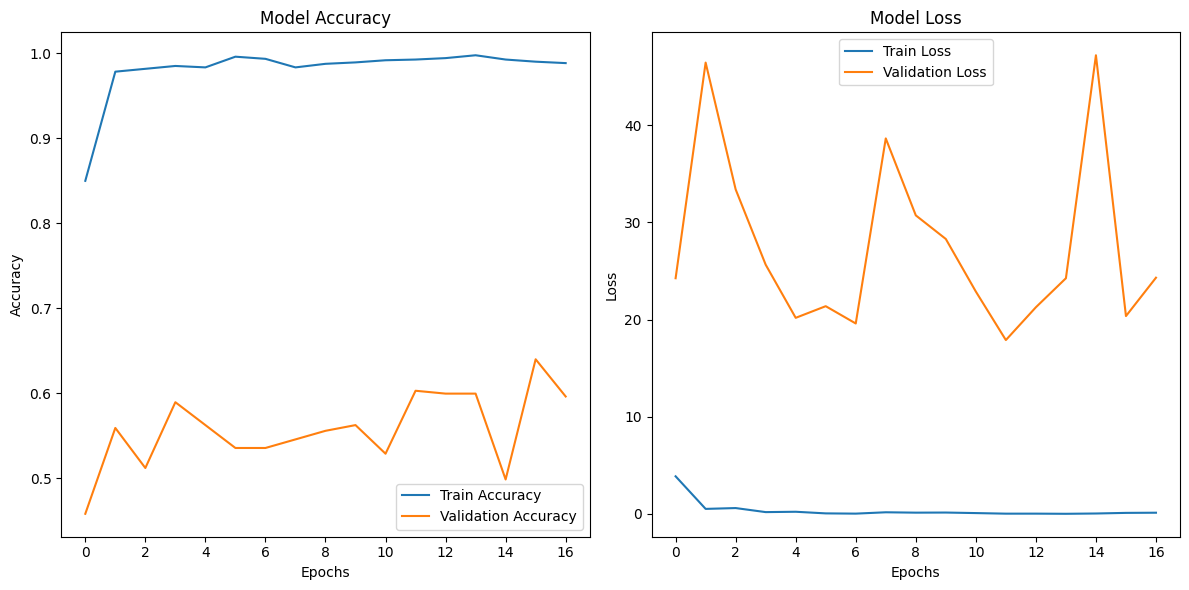

In [8]:
import matplotlib.pyplot as plt

# Extract the training history
history = History.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
final_train_acc = History.history['accuracy'][-1]
final_val_acc = History.history['val_accuracy'][-1]
final_train_loss = History.history['loss'][-1]
final_val_loss = History.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9882
Final Validation Accuracy: 0.5960
Final Training Loss: 0.1237
Final Validation Loss: 24.3023


In [10]:
if 'lr' in History.history:
    plt.plot(History.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

In [11]:
print(f"Training stopped at epoch: {len(History.history['loss'])}")


Training stopped at epoch: 17


# **History Saving**

In [12]:
import json

# Save history to a JSON file on Google Drive
with open("/content/drive/MyDrive/VGG16_Model/Vgg16_Original/training_history.json", "w") as f:
    json.dump(History.history, f)

# Load the history later
with open("/content/drive/MyDrive/VGG16_Model/Vgg16_Original/training_history.json", "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'accuracy': [0.8497061133384705, 0.9781696200370789, 0.981528103351593, 0.984886646270752, 0.9832074046134949, 0.9958018660545349, 0.9932829737663269, 0.9832074046134949, 0.98740553855896, 0.989084780216217, 0.991603672504425, 0.992443323135376, 0.9941225647926331, 0.997481107711792, 0.992443323135376, 0.989924430847168, 0.9882451891899109], 'loss': [3.8687827587127686, 0.5169967412948608, 0.6028630137443542, 0.18598179519176483, 0.22226344048976898, 0.05500388517975807, 0.030301600694656372, 0.1685263216495514, 0.130357563495636, 0.14128103852272034, 0.0862651988863945, 0.026666468009352684, 0.028689345344901085, 0.01290861051529646, 0.043460216373205185, 0.10680676996707916, 0.12367501109838486], 'val_accuracy': [0.4579124450683594, 0.558922529220581, 0.5117844939231873, 0.5892255902290344, 0.5622895359992981, 0.5353535413742065, 0.5353535413742065, 0.5454545617103577, 0.5555555820465088, 0.5622895359992981, 0.5286195278167725, 0.6026936173439026, 0.5993266105651855, 0.5993266105651

# **Model Evaluation Using Test Data**

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
model_path = '/content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_best_model_original.h5'
model = tf.keras.models.load_model(model_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Rotten'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 144s 13s/step
Confusion Matrix:
 [[170  15]
 [  8 180]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.96      0.92      0.94       185
      Rotten       0.92      0.96      0.94       188

    accuracy                           0.94       373
   macro avg       0.94      0.94      0.94       373
weighted avg       0.94      0.94      0.94       373


Accuracy: 0.938337801608579

F1 Score: 0.9399477806788512


In [14]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_results.txt


In [15]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/VGG16_Model/Vgg16_Original/orange_vgg16_confusion_matrix.png
